#                                     Variational Auto-Encoders

In [2]:
import tensorflow as tf
import os
import random
import time
from datetime import datetime
import numpy as np
from tensorflow.keras.datasets import fashion_mnist
from keras.datasets import mnist
from sklearn.metrics import mean_squared_error
from plot_keras_history import show_history, plot_history
print("No. of GPUs available: ", len(tf.config.list_physical_devices('GPU')))

No. of GPUs available:  1


In [3]:
#Splitting the dataset.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
dataset = np.concatenate([x_train], axis=0)  #Preprocessing the dataset.
print(dataset.shape)
dataset = np.expand_dims(dataset, -1).astype("float32") / 255  #Increasing the dimension of the data to 3 layers & Normalizing the dataset from 0 to 1.
print(dataset.shape)

(60000, 28, 28)
(60000, 28, 28, 1)


<Figure size 500x500 with 0 Axes>

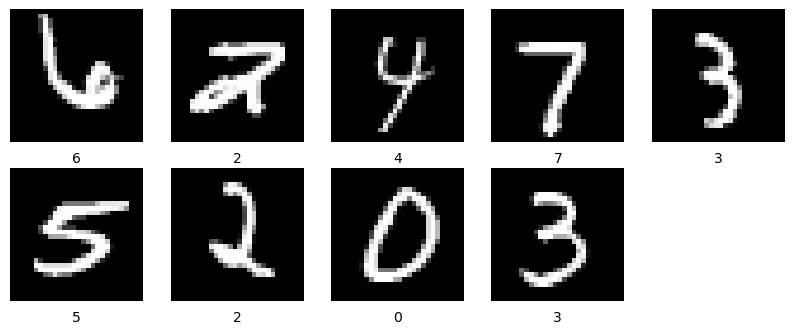

In [162]:
#Testing the images.
from matplotlib import pyplot as plt

plt.figure(figsize=(5, 5))
n = np.random.choice(60000, 9)  #Random Samples
#x_test.reshape(28,28,1)
fig = plt.figure(figsize=(10, 10))
for i in range(9):
     plt.subplot(5,5,i+1)
     plt.imshow(x_train[n[i]], cmap="Greys_r")
     plt.axis('off')
     ax = fig.add_subplot(5, 5, i+1)
     ax.axis('off')
     ax.text(0.5, -0.15, str( y_train[n[i]]), fontsize=10, ha='center', transform=ax.transAxes)
     ax.axis('off')
     
plt.show()

In [163]:
from tensorflow import keras
from tensorflow.keras import layers
#Sampling the layers.
class SamplingLayer(layers.Layer):
      def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [164]:
#Encoder
def Encoder(input_encoder,z_dim):
   
    inputs = keras.Input(shape=input_encoder, name='input_layer')
 
    # Block-1
    x = layers.Conv2D(32, kernel_size=3, strides= 1, padding='same', name='conv_1')(inputs)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
     
    # Block-2
    x = layers.Conv2D(64, kernel_size=3, strides= 2, padding='same', name='conv_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
     
    # Block-3
    x = layers.Conv2D(64, 3, 2, padding='same', name='conv_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
   
    # Block-4
    x = layers.Conv2D(64, 3, 1, padding='same', name='conv_4')(x)
    x = layers.BatchNormalization(name='bn_4')(x)
    x = layers.LeakyReLU(name='lrelu_4')(x)
    
    # Final Block
    flatten = layers.Flatten()(x)
    mean = layers.Dense(z_dim, name='mean')(flatten)
    log_var = layers.Dense(z_dim, name='log_var')(flatten)
    model = tf.keras.Model(inputs, (mean, log_var), name="Encoder")
    return model

#x = keras.Input(shape=(28,28,1))


In [165]:
def Decoder(input_decoder):
     
    inputs = keras.Input(shape=input_decoder, name='input_layer')
    x = layers.Dense(3136, name='dense_1')(inputs)
    x = layers.Reshape((7, 7, 64), name='Reshape_Layer')(x)
    
    # Block-1
    x = layers.Conv2DTranspose(64, 3, strides= 1, padding='same',name='conv_transpose_1')(x)
    x = layers.BatchNormalization(name='bn_1')(x)
    x = layers.LeakyReLU(name='lrelu_1')(x)
   
    # Block-2
    x = layers.Conv2DTranspose(64, 3, strides= 2, padding='same', name='conv_transpose_2')(x)
    x = layers.BatchNormalization(name='bn_2')(x)
    x = layers.LeakyReLU(name='lrelu_2')(x)
     
    # Block-3
    x = layers.Conv2DTranspose(32, 3, 2, padding='same', name='conv_transpose_3')(x)
    x = layers.BatchNormalization(name='bn_3')(x)
    x = layers.LeakyReLU(name='lrelu_3')(x)
     
    # Block-4
    outputs = layers.Conv2DTranspose(1, 3, 1,padding='same', activation='sigmoid', name='conv_transpose_4')(x)
    model = tf.keras.Model(inputs, outputs, name="Decoder")
    return model
#x = keras.Input(shape=(2,))


In [166]:
encode = Encoder((28,28,1), 2)
encode.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 28, 28, 32)   320         ['input_layer[0][0]']            
                                                                                                  
 bn_1 (BatchNormalization)      (None, 28, 28, 32)   128         ['conv_1[0][0]']                 
                                                                                                  
 lrelu_1 (LeakyReLU)            (None, 28, 28, 32)   0           ['bn_1[0][0]']                   
                                                                                            

In [167]:
decode = Decoder(2)
decode.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 2)]               0         
                                                                 
 dense_1 (Dense)             (None, 3136)              9408      
                                                                 
 Reshape_Layer (Reshape)     (None, 7, 7, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 7, 7, 64)          256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 7, 7, 64)          0         
                                                           

In [168]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")
        

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
 
        with tf.GradientTape() as tape:
       
            z_mean, z_log_var = self.encoder(data)
            z = SamplingLayer()([z_mean, z_log_var])
#Loss function
#Reconstruction loss (States the loss of the images that are not similar to the original images)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
        #KlDivergence
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
 
         
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [169]:
#Train vae
vae = VAE(encode, decode)
#vae = tf.keras.models.Model(encode, decode, name="VAE")
vae.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy())
#print(mnist_digits.shape)
start_time = datetime.now()
start = time.time()
print(vae)
hist = vae.fit(dataset, epochs=256, batch_size=64)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
end = time.time()
print("--- %s seconds ---" % (end - start))
#vae
#encode

Epoch 1/256
938/938 [==============================] - 13s 13ms/step - loss: 207.7260 - reconstruction_loss: 174.7337 - kl_loss: 4.3740
Epoch 2/256
938/938 [==============================] - 12s 13ms/step - loss: 164.0864 - reconstruction_loss: 157.5931 - kl_loss: 4.9711
Epoch 3/256
938/938 [==============================] - 12s 13ms/step - loss: 159.5294 - reconstruction_loss: 154.0295 - kl_loss: 5.2480
Epoch 4/256
938/938 [==============================] - 12s 13ms/step - loss: 157.5528 - reconstruction_loss: 152.0210 - kl_loss: 5.3890
Epoch 5/256
938/938 [==============================] - 12s 13ms/step - loss: 155.9583 - reconstruction_loss: 150.5370 - kl_loss: 5.5079
Epoch 6/256
938/938 [==============================] - 12s 13ms/step - loss: 154.9874 - reconstruction_loss: 149.2785 - kl_loss: 5.5976
Epoch 7/256
938/938 [==============================] - 12s 13ms/step - loss: 154.2626 - reconstruction_loss: 148.3945 - kl_loss: 5.6542
Epoch 8/256
938/938 [===========================

938/938 [==============================] - 16s 17ms/step - loss: 141.6421 - reconstruction_loss: 135.0250 - kl_loss: 6.5571
Epoch 120/256
938/938 [==============================] - 15s 16ms/step - loss: 141.9322 - reconstruction_loss: 135.1144 - kl_loss: 6.5579
Epoch 121/256
938/938 [==============================] - 16s 17ms/step - loss: 141.7051 - reconstruction_loss: 135.0825 - kl_loss: 6.5563
Epoch 122/256
938/938 [==============================] - 16s 17ms/step - loss: 141.4963 - reconstruction_loss: 134.9633 - kl_loss: 6.5499
Epoch 123/256
938/938 [==============================] - 15s 16ms/step - loss: 141.5712 - reconstruction_loss: 134.8999 - kl_loss: 6.5616
Epoch 124/256
938/938 [==============================] - 27s 29ms/step - loss: 141.6886 - reconstruction_loss: 134.9151 - kl_loss: 6.5626
Epoch 125/256
938/938 [==============================] - 18s 19ms/step - loss: 141.4630 - reconstruction_loss: 134.7451 - kl_loss: 6.5766
Epoch 126/256
938/938 [=========================

938/938 [==============================] - 14s 15ms/step - loss: 139.0363 - reconstruction_loss: 132.4619 - kl_loss: 6.7272
Epoch 238/256
938/938 [==============================] - 15s 16ms/step - loss: 139.1649 - reconstruction_loss: 132.4726 - kl_loss: 6.7297
Epoch 239/256
938/938 [==============================] - 14s 15ms/step - loss: 138.8710 - reconstruction_loss: 132.3597 - kl_loss: 6.7372
Epoch 240/256
938/938 [==============================] - 15s 16ms/step - loss: 138.8031 - reconstruction_loss: 132.4048 - kl_loss: 6.7272
Epoch 241/256
938/938 [==============================] - 14s 15ms/step - loss: 138.7321 - reconstruction_loss: 132.3961 - kl_loss: 6.7354
Epoch 242/256
938/938 [==============================] - 15s 16ms/step - loss: 138.8811 - reconstruction_loss: 132.4917 - kl_loss: 6.7344
Epoch 243/256
938/938 [==============================] - 15s 15ms/step - loss: 138.7276 - reconstruction_loss: 132.2821 - kl_loss: 6.7354
Epoch 244/256
938/938 [=========================

<Figure size 500x500 with 0 Axes>

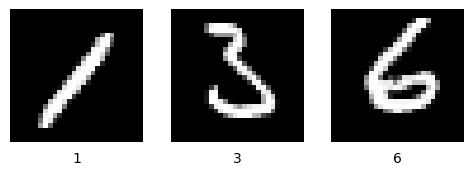

In [193]:
plt.figure(figsize=(5, 5))
n = np.random.choice(10000, 3) #Random Samples
#print(n)
#x_test.reshape(28,28,1)
fig = plt.figure(figsize=(10, 10))
for i in range(3):
     plt.subplot(5,5,i+1)
     plt.imshow(x_test[n[i]], cmap="Greys_r")
     plt.axis('off')
     ax = fig.add_subplot(5, 5, i+1)
     ax.axis('off')
     ax.text(0.5, -0.15, str( y_test[n[i]]), fontsize=10, ha='center', transform=ax.transAxes)
     ax.axis('off')
     
plt.show()

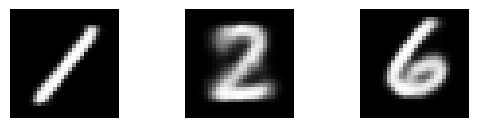

In [194]:
for i in range(3):
    batch = np.expand_dims(x_test[n[i]], axis=0)
    batchOfimg = np.expand_dims(batch, axis=-1).astype("float32")/255
    m,v = vae.encoder.predict(batchOfimg)
    z = SamplingLayer()([m,v])
    s = vae.decoder.predict([z])
    z
    plt.subplot(3,3,i+1)
    plt.imshow(s[0], cmap="Greys_r")
    plt.axis('off')
    ax = fig.add_subplot(5, 5, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str( y_test[n[i]]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.axis('off')
     
plt.show()

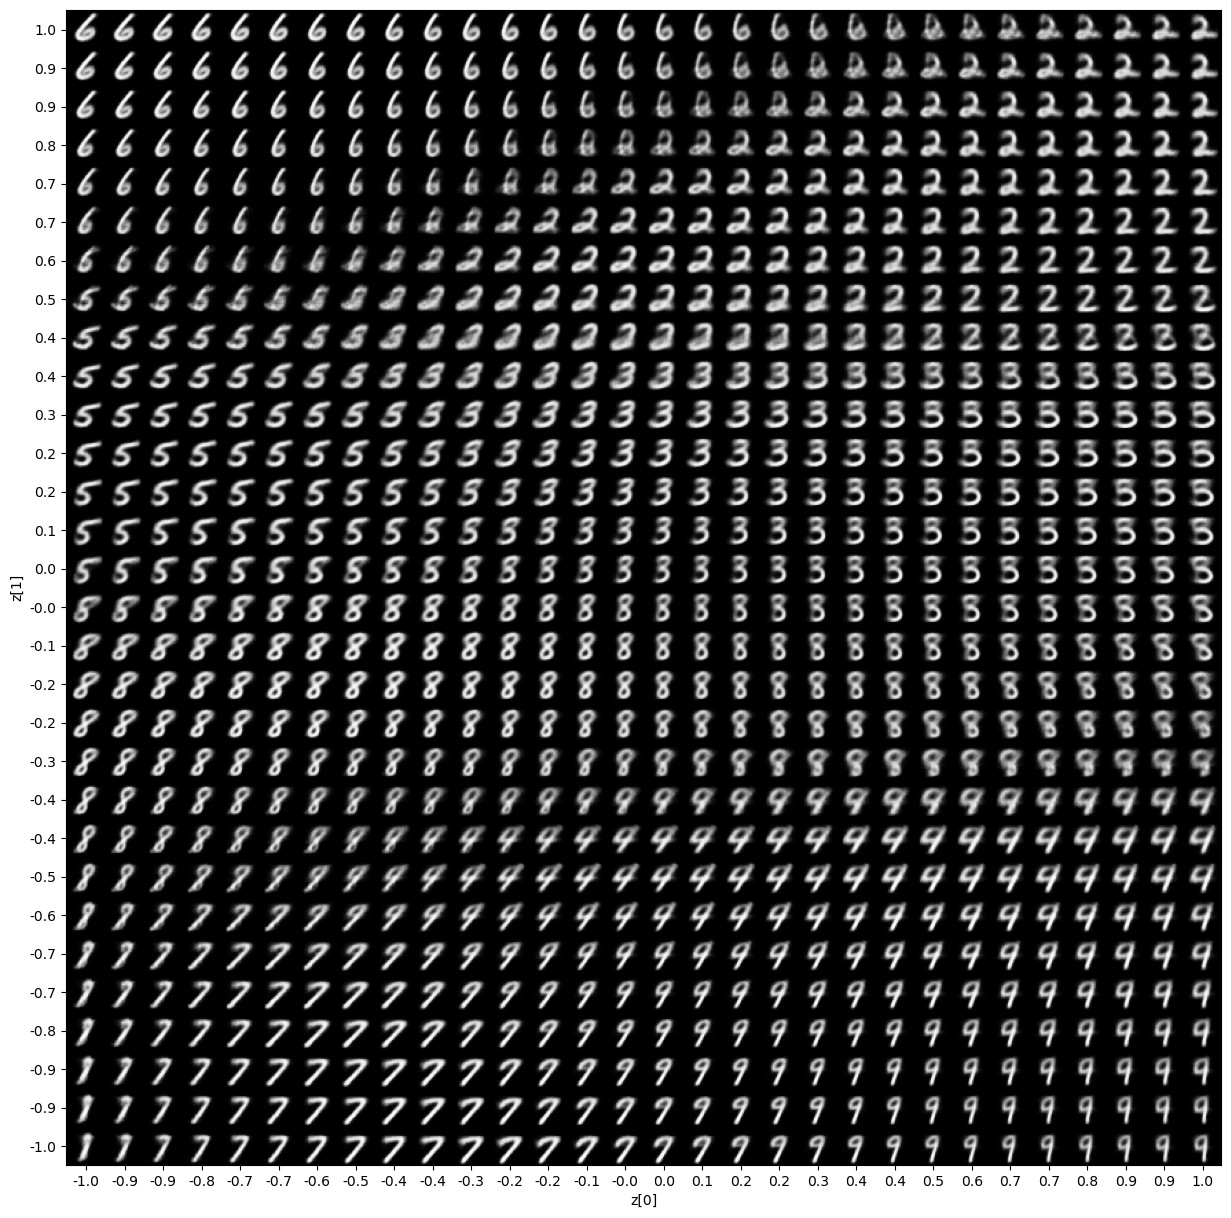

In [172]:
def plot_latent_space(vae, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
plot_latent_space(vae)

<Figure size 1000x900 with 0 Axes>

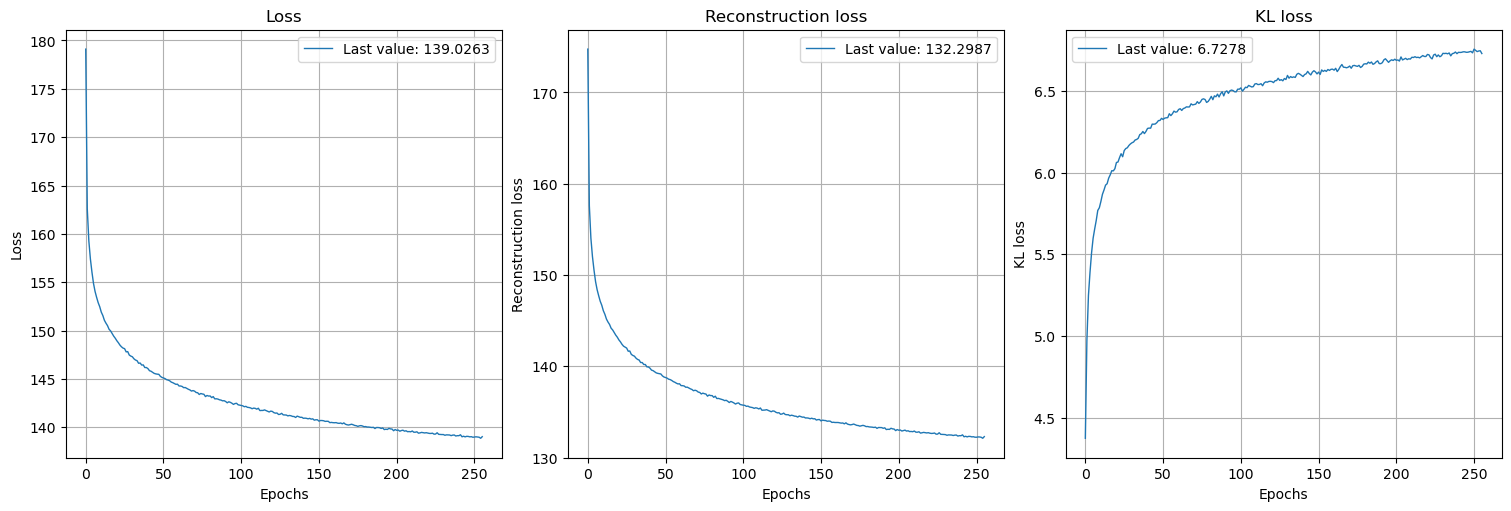

In [173]:
plt.figure(figsize=(10,9))
show_history(hist)

In [174]:
encoder = Encoder((28,28,1), 100)
encoder.summary()

Model: "Encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_layer (InputLayer)       [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv_1 (Conv2D)                (None, 28, 28, 32)   320         ['input_layer[0][0]']            
                                                                                                  
 bn_1 (BatchNormalization)      (None, 28, 28, 32)   128         ['conv_1[0][0]']                 
                                                                                                  
 lrelu_1 (LeakyReLU)            (None, 28, 28, 32)   0           ['bn_1[0][0]']                   
                                                                                            

In [175]:
decoder = Decoder(100)
decoder.summary()

Model: "Decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 100)]             0         
                                                                 
 dense_1 (Dense)             (None, 3136)              316736    
                                                                 
 Reshape_Layer (Reshape)     (None, 7, 7, 64)          0         
                                                                 
 conv_transpose_1 (Conv2DTra  (None, 7, 7, 64)         36928     
 nspose)                                                         
                                                                 
 bn_1 (BatchNormalization)   (None, 7, 7, 64)          256       
                                                                 
 lrelu_1 (LeakyReLU)         (None, 7, 7, 64)          0         
                                                           

In [176]:
#Train vae
vae1 = VAE(encoder, decoder)
#vae = tf.keras.models.Model(encode, decode, name="VAE")
vae1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy())
#print(mnist_digits.shape)
start_time = datetime.now()
start = time.time()
#print(vae1)
history = vae1.fit(dataset, epochs=256, batch_size=64)
end_time = datetime.now()
print('Duration: {}'.format(end_time - start_time))
end = time.time()
print("--- %s seconds ---" % (end - start))
#vae
#encode

Epoch 1/256
938/938 [==============================] - 15s 15ms/step - loss: 175.3386 - reconstruction_loss: 109.0064 - kl_loss: 25.9965
Epoch 2/256
938/938 [==============================] - 13s 14ms/step - loss: 109.2749 - reconstruction_loss: 80.4190 - kl_loss: 27.6701
Epoch 3/256
938/938 [==============================] - 13s 14ms/step - loss: 105.8039 - reconstruction_loss: 77.8792 - kl_loss: 27.6268
Epoch 4/256
938/938 [==============================] - 13s 14ms/step - loss: 104.4042 - reconstruction_loss: 76.6972 - kl_loss: 27.5080
Epoch 5/256
938/938 [==============================] - 13s 14ms/step - loss: 103.3479 - reconstruction_loss: 75.9600 - kl_loss: 27.3462
Epoch 6/256
938/938 [==============================] - 14s 15ms/step - loss: 102.7274 - reconstruction_loss: 75.4592 - kl_loss: 27.2078
Epoch 7/256
938/938 [==============================] - 14s 15ms/step - loss: 102.0869 - reconstruction_loss: 75.0292 - kl_loss: 27.0835
Epoch 8/256
938/938 [==========================

938/938 [==============================] - 15s 16ms/step - loss: 94.0095 - reconstruction_loss: 69.5861 - kl_loss: 24.4403
Epoch 122/256
938/938 [==============================] - 24s 26ms/step - loss: 94.0430 - reconstruction_loss: 69.5811 - kl_loss: 24.4508
Epoch 123/256
938/938 [==============================] - 16s 17ms/step - loss: 94.1314 - reconstruction_loss: 69.5443 - kl_loss: 24.4488
Epoch 124/256
938/938 [==============================] - 15s 16ms/step - loss: 94.1154 - reconstruction_loss: 69.5762 - kl_loss: 24.4488
Epoch 125/256
938/938 [==============================] - 18s 19ms/step - loss: 94.0953 - reconstruction_loss: 69.5623 - kl_loss: 24.4743
Epoch 126/256
938/938 [==============================] - 25s 27ms/step - loss: 93.8751 - reconstruction_loss: 69.5431 - kl_loss: 24.4217
Epoch 127/256
938/938 [==============================] - 14s 15ms/step - loss: 93.9107 - reconstruction_loss: 69.5236 - kl_loss: 24.4322
Epoch 128/256
938/938 [==============================] 

938/938 [==============================] - 16s 17ms/step - loss: 92.7693 - reconstruction_loss: 68.8302 - kl_loss: 24.1009
Epoch 240/256
938/938 [==============================] - 17s 19ms/step - loss: 92.8127 - reconstruction_loss: 68.8167 - kl_loss: 24.1087
Epoch 241/256
938/938 [==============================] - 16s 17ms/step - loss: 92.7678 - reconstruction_loss: 68.8191 - kl_loss: 24.0744
Epoch 242/256
938/938 [==============================] - 16s 17ms/step - loss: 92.8358 - reconstruction_loss: 68.8122 - kl_loss: 24.1244
Epoch 243/256
938/938 [==============================] - 16s 17ms/step - loss: 92.7774 - reconstruction_loss: 68.8030 - kl_loss: 24.0712
Epoch 244/256
938/938 [==============================] - 20s 21ms/step - loss: 92.9823 - reconstruction_loss: 68.7968 - kl_loss: 24.0935
Epoch 245/256
938/938 [==============================] - 16s 17ms/step - loss: 92.8731 - reconstruction_loss: 68.7871 - kl_loss: 24.0625
Epoch 246/256
938/938 [==============================] 

<Figure size 500x500 with 0 Axes>

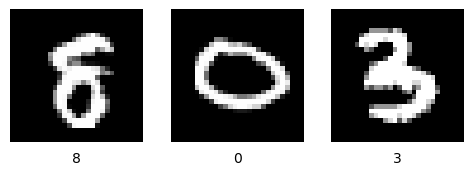

In [177]:
plt.figure(figsize=(5, 5))
n = np.random.choice(10000, 3) #Random Samples
#print(n)
#x_test.reshape(28,28,1)
fig = plt.figure(figsize=(10, 10))
for i in range(3):
     plt.subplot(5,5,i+1)
     plt.imshow(x_test[n[i]], cmap="Greys_r")
     plt.axis('off')
     ax = fig.add_subplot(5, 5, i+1)
     ax.axis('off')
     ax.text(0.5, -0.15, str( y_test[n[i]]), fontsize=10, ha='center', transform=ax.transAxes)
     ax.axis('off')
     
plt.show()

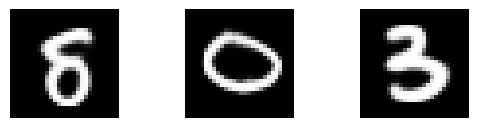

In [185]:
#idx = 100
for i in range(3):
    batch = np.expand_dims(x_test[n[i]], axis=0)
    batchOfimg = np.expand_dims(batch, axis=-1).astype("float32")/255
    m,v = vae1.encoder.predict(batchOfimg)
    z = SamplingLayer()([m,v])
    s = vae1.decoder.predict([z])
    z
    plt.subplot(3,3,i+1)
    plt.imshow(s[0], cmap="Greys_r")
    plt.axis('off')
    ax = fig.add_subplot(3, 3, i+1)
    ax.axis('off')
    ax.text(0.5, -0.15, str( y_test[n[i]]), fontsize=10, ha='center', transform=ax.transAxes)
    ax.axis('off')
     
plt.show()

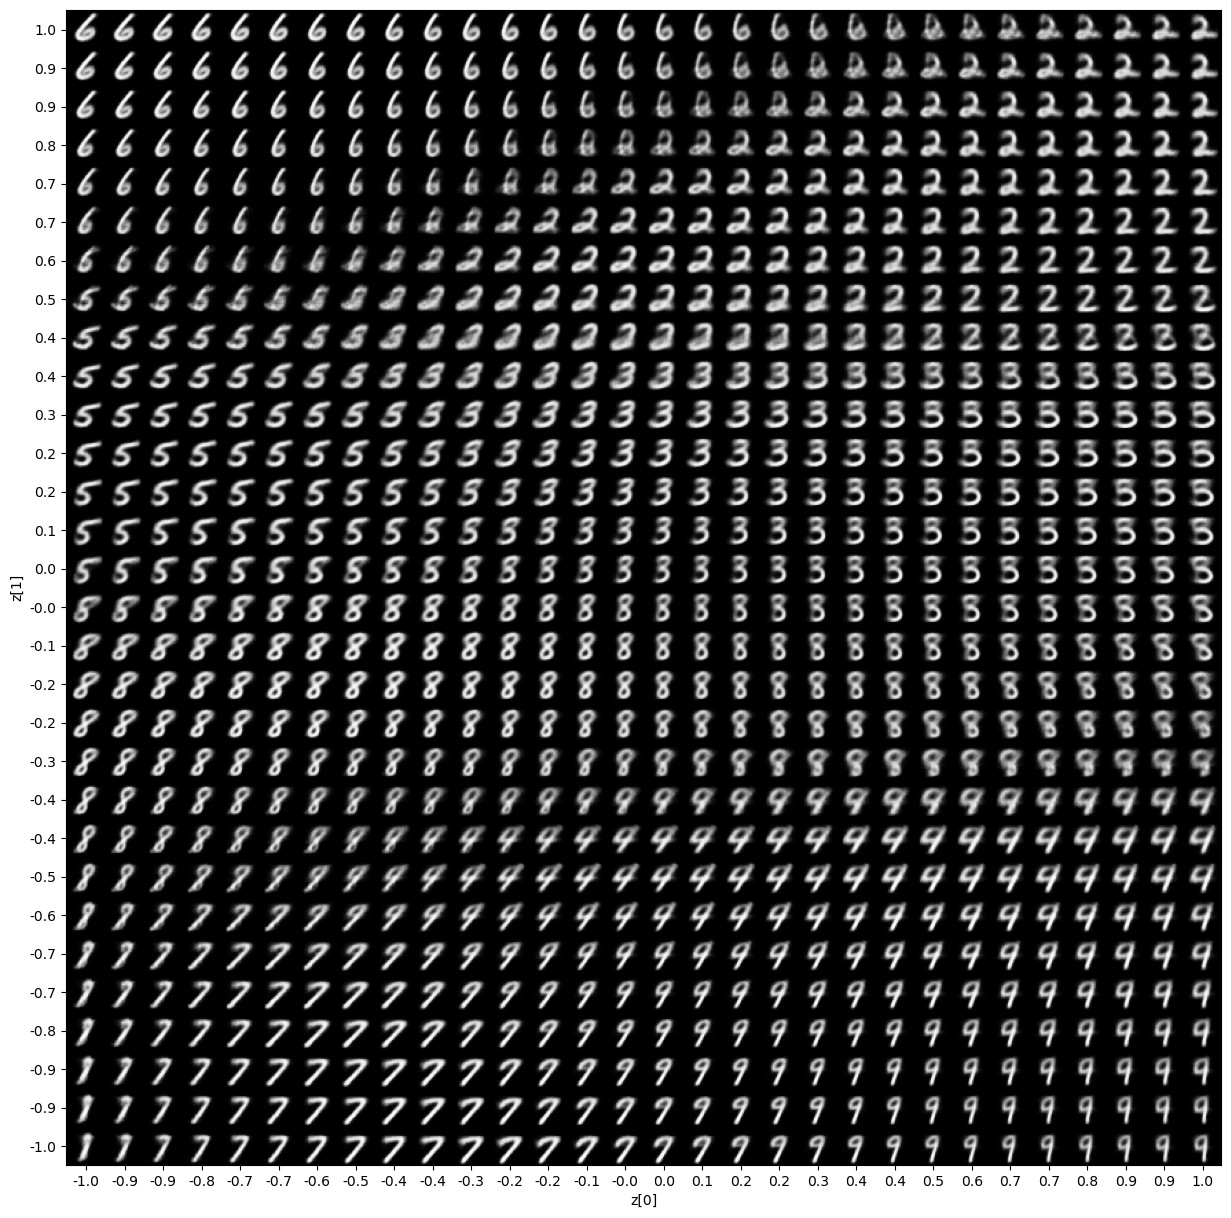

In [179]:
def plot_latent_space(vae1, n=30, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 28
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae1.decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap="Greys_r")
    plt.show()
plot_latent_space(vae)

<Figure size 1000x900 with 0 Axes>

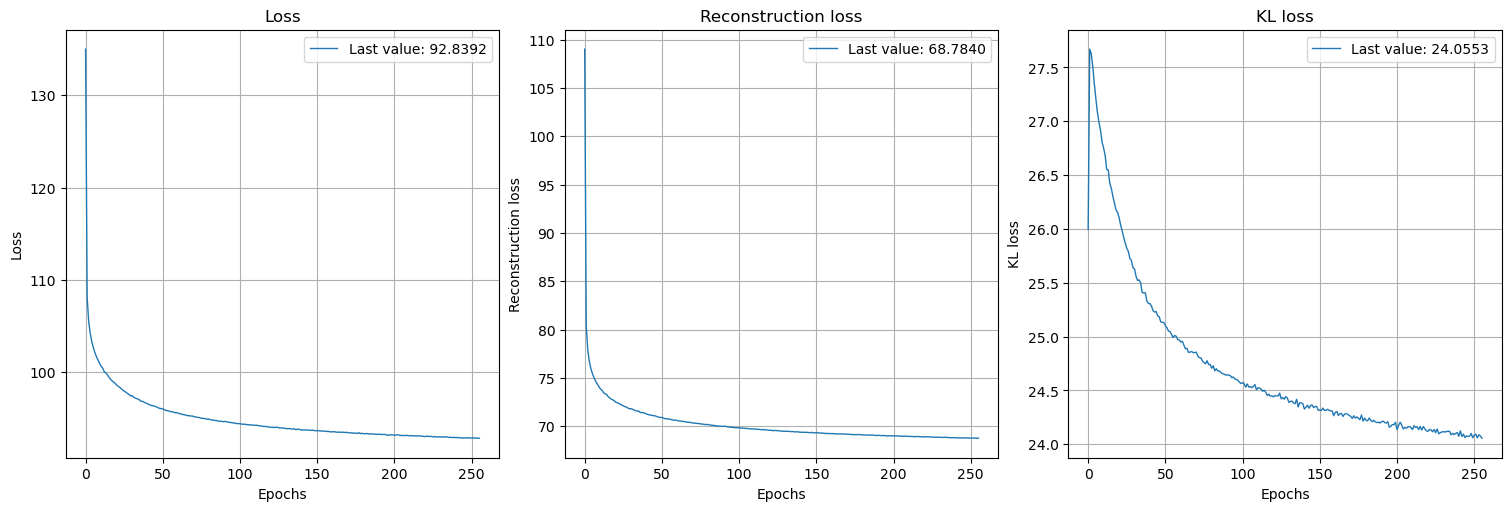

In [180]:
plt.figure(figsize=(10,9))
show_history(history)
#plot_history(history)
#plt.plot(history.history.get('total_loss'), label="Total loss")
#plt.plot(history.history.get('reconstruction_loss'), label="Reconstruction loss")
#plt.plot(history.history.get('kl_loss'), label="KL loss")

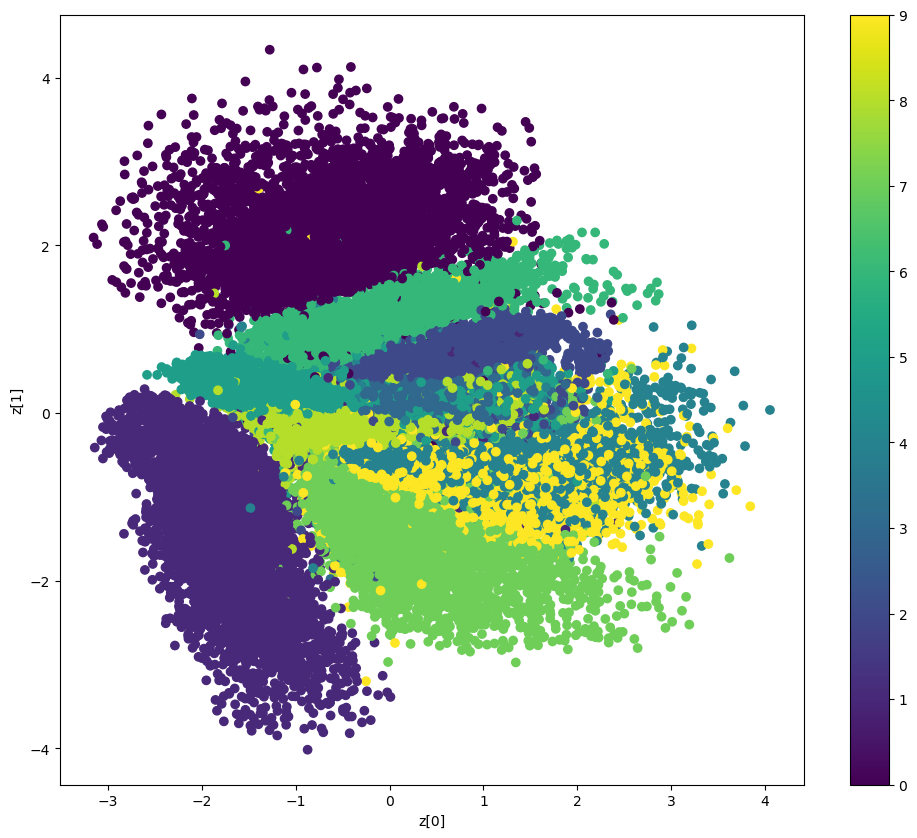

In [181]:
def plot_label_clusters(vae1, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _ = vae1.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


(x_train, y_train), _ = keras.datasets.mnist.load_data()
x_train = np.expand_dims(x_train, -1).astype("float32") / 255

plot_label_clusters(vae, x_train, y_train)